In [1]:
import re
import os 
import pandas as pd
import numpy as np

In [2]:
path = 'C:\\jupyter-notebook-files\\py3\\供电量数据'
files = os.listdir(path)

In [3]:
os.chdir(path)

In [4]:
os.getcwd()

'C:\\jupyter-notebook-files\\py3\\供电量数据'

In [4]:
data_csv = pd.read_csv('ElectricityDataSet.csv')
# data_csv = pd.read_csv('newElectricityDataDaySet.csv')

In [5]:
data_clip = data_csv['Date'].str.split('/',expand=True)
df_year = data_clip[0]
df_month = data_clip[1]
df_day = data_clip[2]

In [6]:
data_csv['year'] = df_year
data_csv['month'] = df_month
data_csv['day'] = df_day

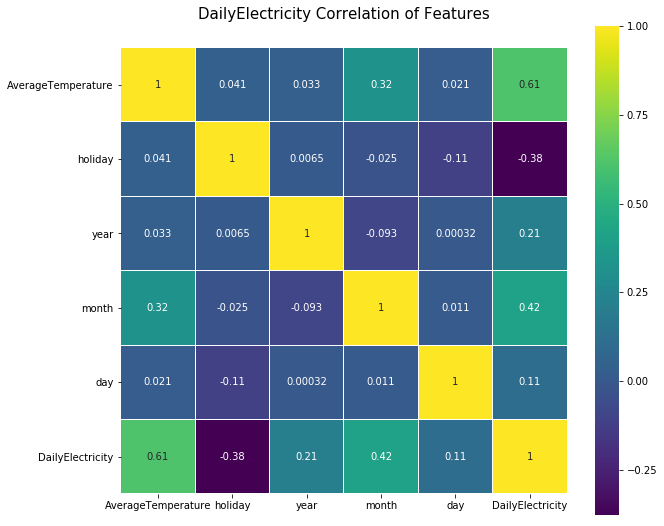

In [44]:
import seaborn as sns
Correlation = pd.DataFrame(data_csv[['AverageTemperature', 'holiday', 'year', 'month', 'day', 'DailyElectricity']])
colormap = plt.cm.viridis
plt.figure(figsize=(10,9))
plt.title('DailyElectricity Correlation of Features', y=1.05, size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# 特征工程

In [22]:
# x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [8]:
X = data_csv[['AverageTemperature','holiday','year','month','day']]
Y = data_csv[['DailyElectricity']]
#######################################################################
# X = data_csv[['AverageTemperature','holiday','year','month','day','Season','GDP']]
# Y = data_csv[['DailyElectricity']]

In [11]:
# 归一化
from sklearn import preprocessing

In [12]:
X_scl = preprocessing.scale(X)

In [13]:
# scaled之后的数据零均值，单位方差
print (X_scl.mean(axis=0))
print (X_scl.std(axis=0)) 

[ 1.01506105e-16  3.86992026e-17  4.95349793e-14 -9.13554946e-17
  9.38931472e-17]
[1. 1. 1. 1. 1.]


In [33]:
# x_train,x_test,y_train,y_test = train_test_split(X_scl,Y.values.ravel(),test_size=0.3,random_state=0)

In [45]:
# clf_rf = RandomForestRegressor(n_estimators=100,max_features=.9)
# clf_rf.fit(x_train,y_train)
# clf_rf.score(x_test,y_test)

In [14]:
#x[1364:]，y[1364:]
x_train = X_scl[:1364]
y_train = Y[:1364]
x_test = X_scl[1364:]
y_test = Y[1364:]

# 高斯过程回归

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C# REF就是高斯核函数  

In [16]:
#核函数
kernel = C(0.1, (0.001,0.1))*RBF(0.5,(1e-4,1000))

In [17]:
reg = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10,alpha=0.1)

In [18]:
reg.fit(x_train,y_train)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=0.5),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [21]:
reg.score(x_test,y_test)

0.5932574721141814

In [19]:
result_GPR = reg.predict(x_test)

In [120]:
# len(result_GPR)

In [20]:
result_9 = result_GPR[0:5].sum() + y_train.values[-25:].sum() #GPR 2017 9 的total electricity 
result_10 = result_GPR[5:36].sum()#GPR 2017 10 的total electricity 
print (result_9)
print (result_10)

7589440.631858522
6318227.407847051


In [42]:
1-abs(7589440.631858522-7698168)/7698168

0.9858762022157118

In [43]:
1-abs(6318227.407847051-6377044)/6377044.0

0.9907768251006345

# 随机森林

In [28]:
#随机森林
#交叉验证
from sklearn.ensemble import RandomForestRegressor
# max_features = [.1,.6,.7,.8,.9,1]
max_features = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
test_loss = []
test_accuarcy = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=100,max_features=max_feat)
    loss = -cross_val_score(clf,x_train,y_train.values.ravel(),cv=5,scoring='neg_mean_squared_error')#loss 损失函数
    test_loss.append(loss.mean())

Text(0.5,1,'RF')

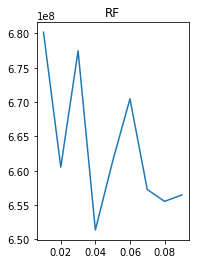

In [29]:
plt.subplot(1,2,1)
plt.plot(max_features,test_loss)
plt.title("RF")

In [30]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=100,max_features=0.04)
clf_rf.fit(x_train,y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.04, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
clf_rf.score(x_test,y_test)

0.6762894541488895

In [33]:
result_rf = clf_rf.predict(x_test)
result_9 = result_rf[0:5].sum() + y_train.values[-25:].sum() #rf 2017 9 的total electricity 
result_10 = result_rf[5:36].sum()#rf 2017 10 的total electricity 
print (result_9)
print (result_10)

7633942.33
6373458.989999999


In [40]:
1-abs(7633942.33-7698168)/7698168

0.9916570189167085

In [41]:
1-abs(6373458.989999999-6377044)/6377044.0

0.9994378257386963